In [ ]:
# !pip install pydicom

In [ ]:
# !pip install git+https://github.com/shijianjian/EfficientNet-PyTorch-3D

In [1]:
import os
import sys 
import json
import glob
import random
import collections
import time
import re

import numpy as np
import pandas as pd
import pydicom
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils import data as torch_data
from sklearn import model_selection as sk_model_selection
from torch.nn import functional as torch_functional
import torch.nn.functional as F

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

from pathlib import Path
from efficientnet_pytorch_3d import EfficientNet3D

from tqdm.notebook import tqdm

from functools import cmp_to_key

In [2]:
class Config():
    epochs = 10
    batch_size = 1
    base_path = Path('/home/RSNA_MICCAI_Brain_Tumor/data')
    assert base_path.exists()
    models_path = Path('/home/RSNA_MICCAI_Brain_Tumor/models')
    assert models_path.exists()
    seed = 42
    num_workers = 7
    model_name = 'efficientnet3d-0'
    lr = 5e-3
    
cfg = Config()

In [3]:
if os.path.exists(cfg.base_path):
    data_directory = cfg.base_path
else:
    assert False, "data_directory does not exist"
    
# mri_types = ['FLAIR']
mri_types = ['FLAIR','T1w','T1wCE','T2w']
SIZE = 256
NUM_IMAGES = 16

### Functions to load images

In [4]:
def cropped_images(images):
    min=np.array(np.nonzero(images)).min(axis=1)
    max=np.array(np.nonzero(images)).max(axis=1)
    return images[min[0]:max[0],min[1]:max[1],min[2]:max[2]]

def load_dicom_image(path, img_size=SIZE):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if np.min(data)==np.max(data):
        data = np.zeros((img_size,img_size))
        return data
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    
    #data = (data * 255).astype(np.uint8)
    data = cv2.resize(data, (img_size, img_size))
    return data

def convert_path_to_int(x):
    res = int(re.sub(r'.+\-+(\d+)\..+', r'\1', x))
    return res


def load_dicom_images_3d(scan_id, num_imgs=NUM_IMAGES, img_size=SIZE, mri_type="FLAIR", split="train"):

    glob_expr = f'{cfg.base_path}/{split}/{scan_id}/{mri_type}/*.dcm'
    files = glob.glob(glob_expr)
    files.sort(key=cmp_to_key(lambda x, y: -1 if convert_path_to_int(x) < convert_path_to_int(y) else 1))
    
    
    middle = len(files)//2
    num_imgs2 = num_imgs//2
    p1 = max(0, middle - num_imgs2)
    p2 = min(len(files), middle + num_imgs2)
    img3d = np.stack([load_dicom_image(f) for f in files[p1:p2]]).T 
    if img3d.shape[-1] < num_imgs:
        n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
        img3d = np.concatenate((img3d,  n_zero), axis = -1)
#     img3d = cropped_images(img3d)
    return np.expand_dims(img3d,0)[:,20:236,20:236,:]

In [5]:
sample_img = load_dicom_images_3d("00000")
sample_img.shape

(1, 216, 216, 16)

In [6]:
def show_scans(scan_id, images=4, offset=0):
    fig = plt.figure(figsize=(50, 50))
    fig.axis('off')
    for i, j in enumerate(range(offset, offset + images), 1):
        fig.add_subplot(1, images, i)
        plt.imshow(np.moveaxis(load_dicom_images_3d(scan_id).squeeze(), -1, 0)[j])

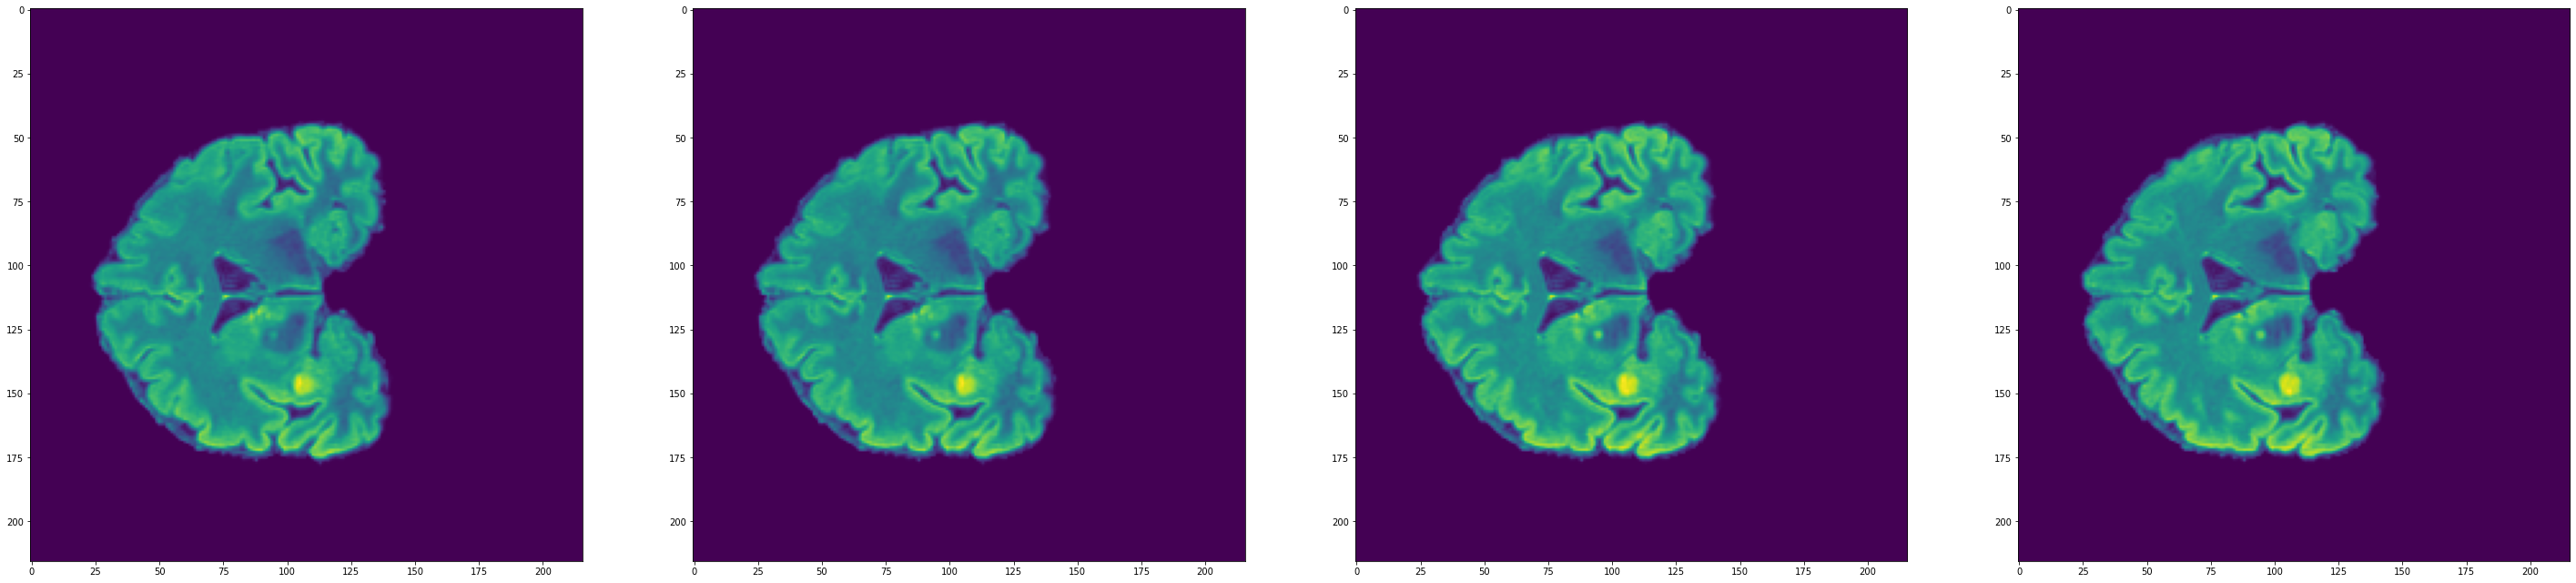

In [7]:
show_scans("00000", 4, 10)

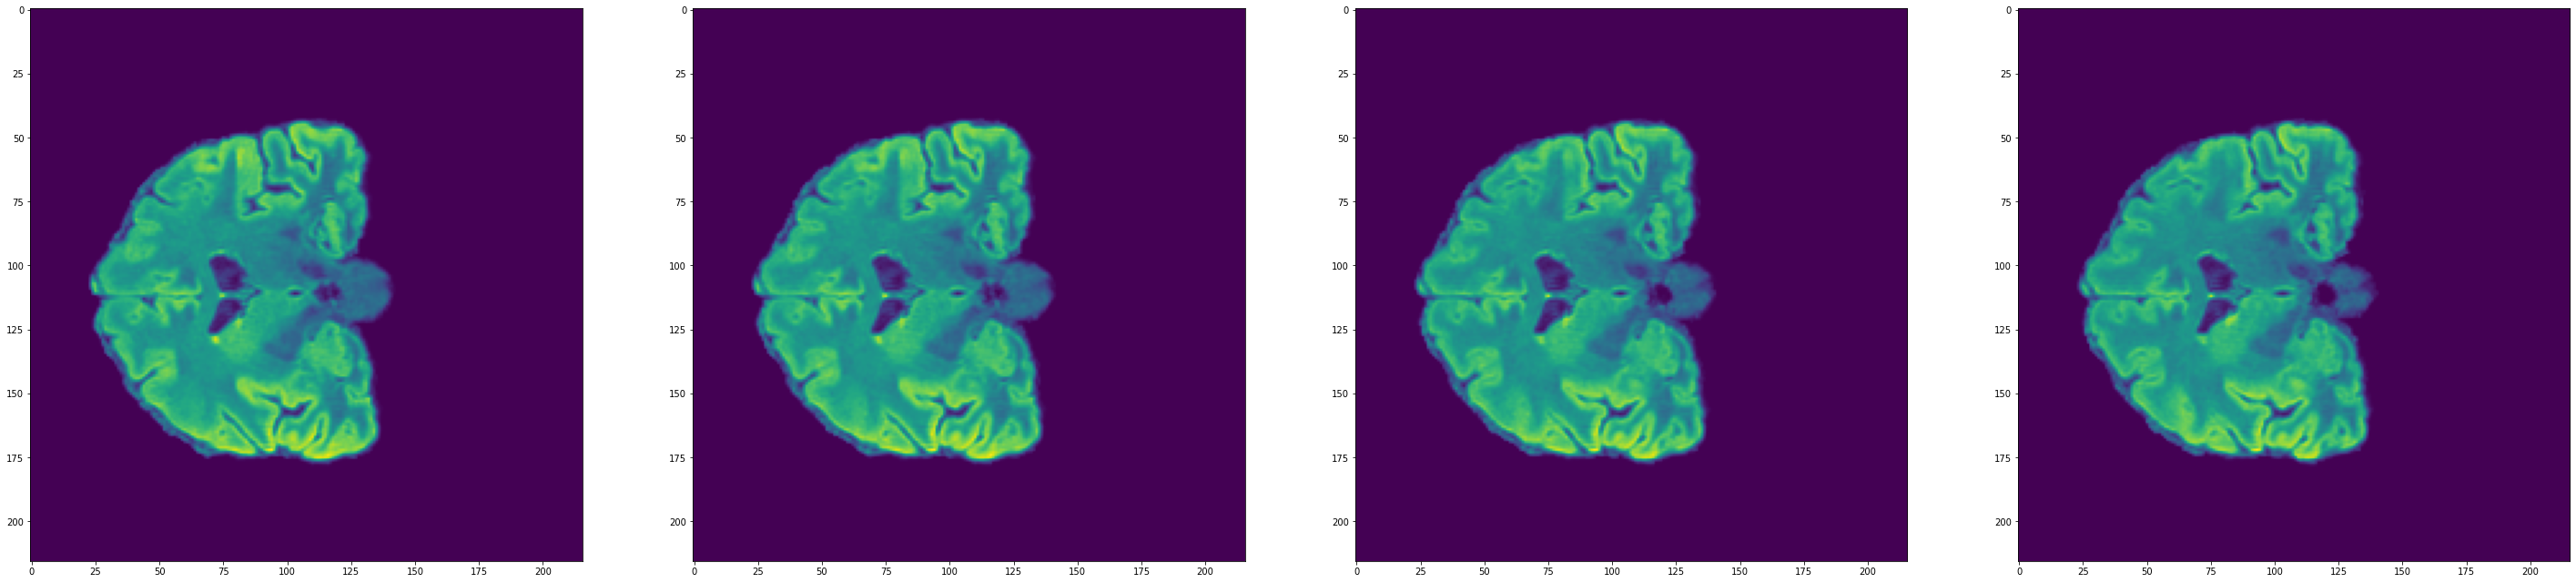

In [8]:
show_scans("00000", 4, 1)

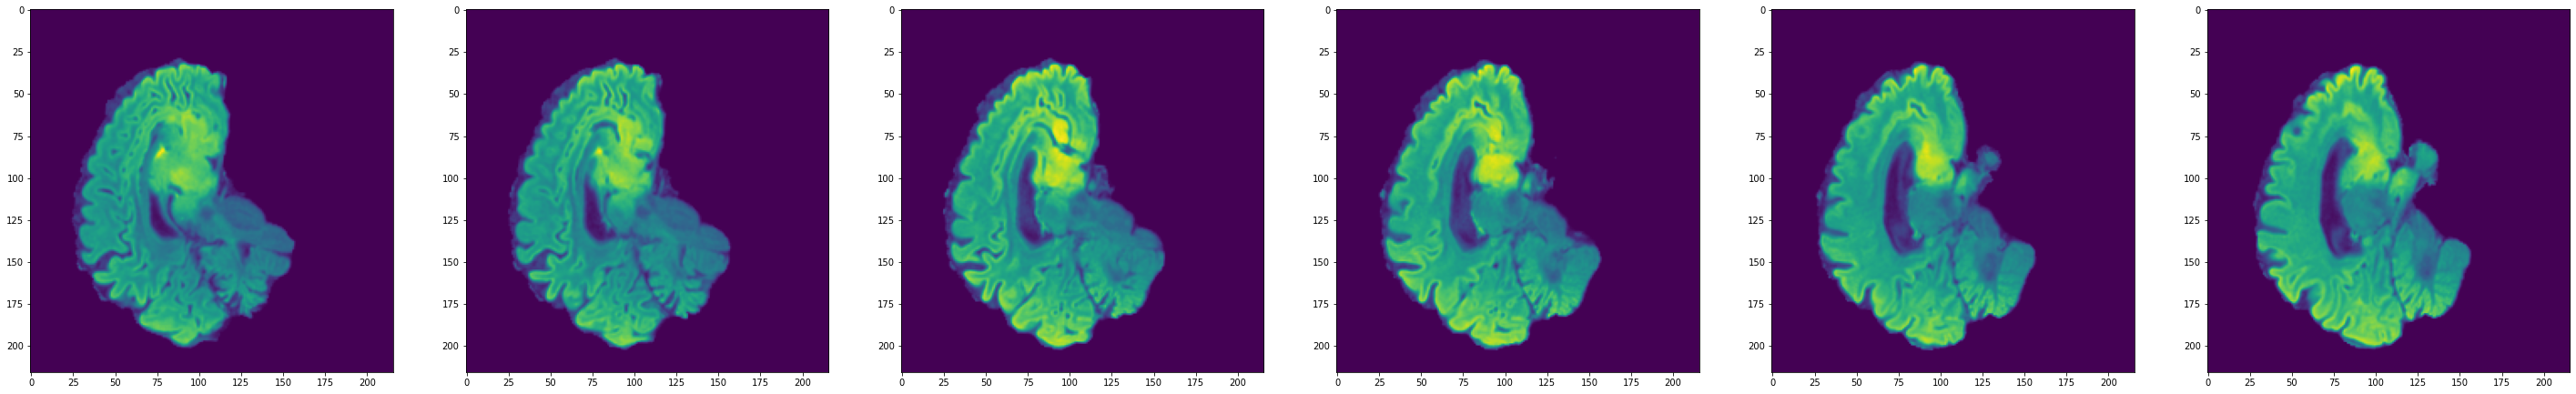

In [9]:
show_scans("00002", 6, 10)

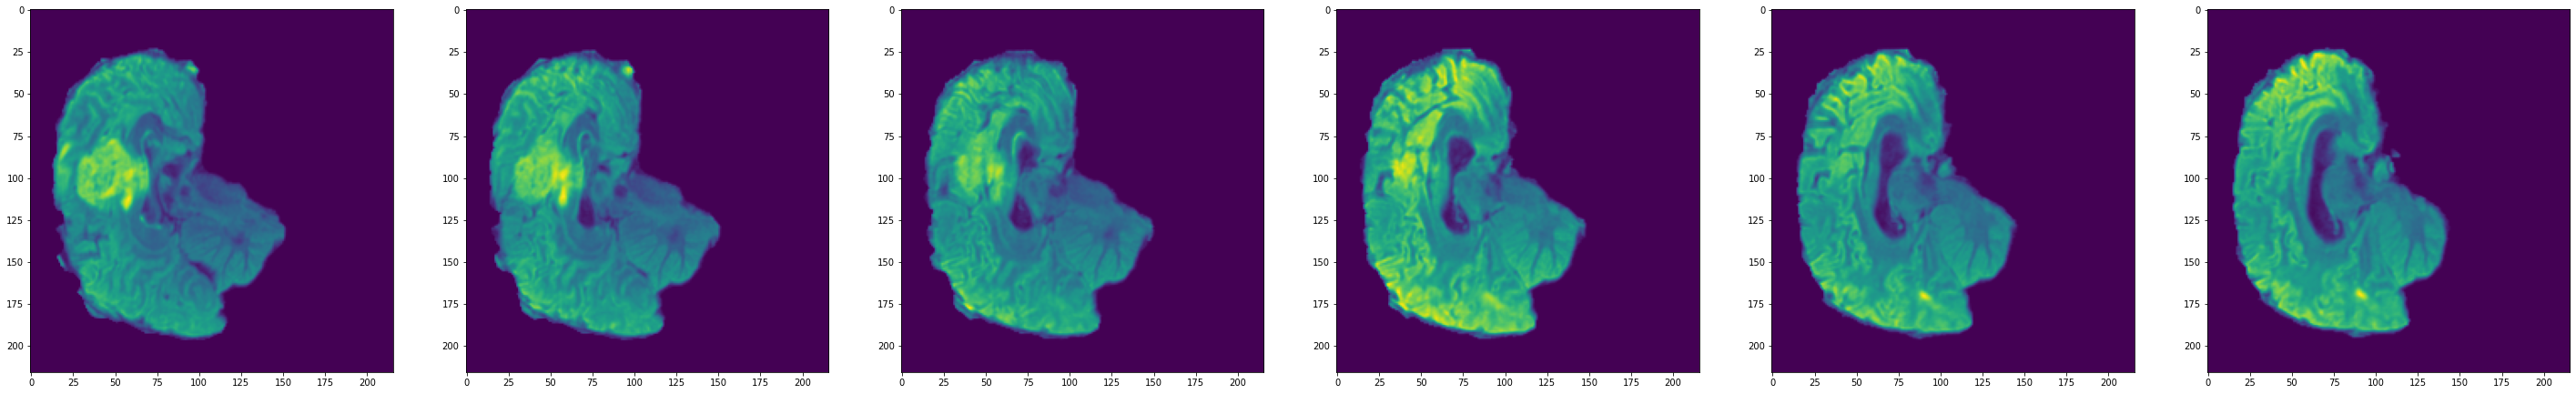

In [10]:
show_scans("00003", 6, 10)

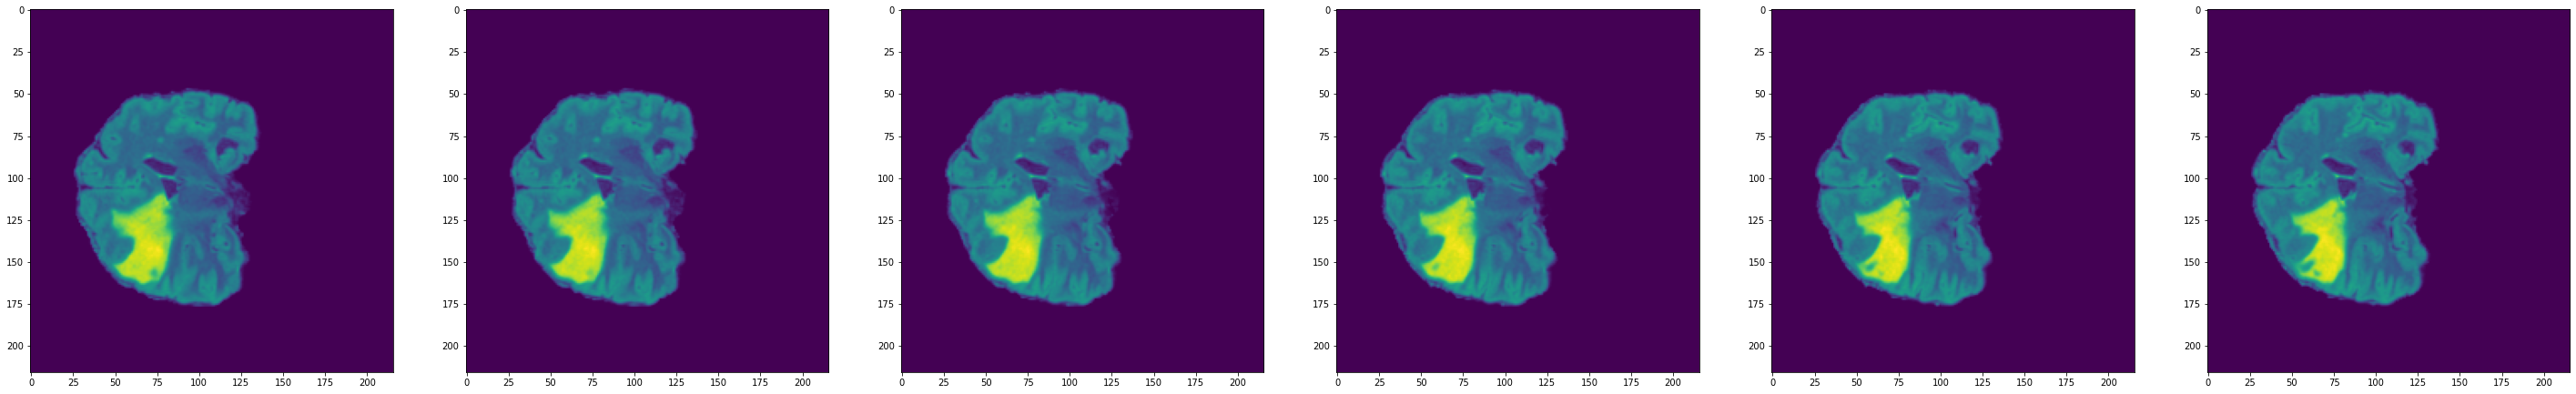

In [11]:
show_scans("00005", 6, 10)

### train / test splits

In [12]:
train_df = pd.read_csv(f"{data_directory}/train_labels.csv")
display(train_df)

BraTS21ID  MGMT_value
0            0           1
1            2           1
2            3           0
3            5           1
4            6           1
..         ...         ...
580       1005           1
581       1007           1
582       1008           1
583       1009           0
584       1010           0

[585 rows x 2 columns]

In [13]:
train_df = train_df.drop(train_df[train_df['BraTS21ID'].isin([109, 123, 709])].index)

In [14]:
df_train, df_valid = sk_model_selection.train_test_split(
    train_df, 
    test_size=0.05, 
    random_state=42, 
    stratify=train_df["MGMT_value"],
)

In [15]:
df_train.tail()

BraTS21ID  MGMT_value
15          22           0
366        540           0
504        735           0
426        615           1
9           14           1

In [16]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(cfg.seed)

### Model and training classes

In [17]:
from torchvision import transforms
import torchvision

flipper = transforms.RandomHorizontalFlip()
def flipper_forward(img):
    """
    Args:
        img (PIL Image or Tensor): Image to be flipped.

    Returns:
        PIL Image or Tensor: Randomly flipped image.
    """
    randn = torch.rand(1)
    if randn < flipper.p:
        return torchvision.transforms.functional.hflip(img)
    return img

flipper.forward = flipper_forward
flipper(torch.randn([1, 256, 256, 64])).shape

torch.Size([1, 256, 256, 64])

In [18]:
auto_contrast = transforms.RandomAutocontrast()

In [19]:
auto_contrast(torch.randn([8, 3, 256, 256])).shape

torch.Size([8, 3, 256, 256])

In [20]:
from torchvision import transforms
from torchvision.transforms import Compose

augmentations = Compose([
    transforms.Lambda(lambda x: torch.Tensor(x).float()),
    flipper,
    transforms.RandomVerticalFlip(),
    auto_contrast
])

In [21]:
transforms.RandomRotation(23)

RandomRotation(degrees=[-23.0, 23.0], interpolation=nearest, expand=False)

In [22]:
class Dataset(torch_data.Dataset):
    def __init__(self, paths, targets=None, mri_type=None, label_smoothing=0.01, split="train"):
        self.paths = paths
        self.targets = targets
        self.mri_type = mri_type
        self.label_smoothing = label_smoothing
        self.split = split
          
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        scan_id = self.paths[index]
        if self.targets is None:
            data = load_dicom_images_3d(str(scan_id).zfill(5), mri_type=self.mri_type[index], split=self.split)
        else:
            data = load_dicom_images_3d(str(scan_id).zfill(5), mri_type=self.mri_type[index], split="train")
        
        data = data.transpose(-1, 0, 1, 2)
        
        data = augmentations(data)
        data = data.permute(1, 2, 3, 0)
        
        data = torch.cat([data, data, data], axis=0)
        data = data.permute(-1, 0, 1, 2)
        if self.targets is None:
            return {"X": data, "id": scan_id}
        else:
            y = torch.tensor(abs(self.targets[index]-self.label_smoothing), dtype=torch.float)
            return {"X": data, "y": y}


In [23]:
from efficientnet_pytorch import EfficientNet

class ModelHead(nn.Module):
    
    def __init__(self, in_features, hidden_dim):
        super().__init__()
        self._fc = nn.Linear(in_features=in_features, out_features=hidden_dim, bias=True)
        self._fc_2 = nn.Linear(in_features=hidden_dim, out_features=1, bias=True)
        
    def forward(self, x):
        x = self._fc(x)
        x = self._fc_2(x)
        return x

class Model_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = EfficientNet3D.from_name("efficientnet-b0", override_params={'num_classes': 2}, in_channels=1)
        n_features = self.net._fc.in_features
        self.net._fc = ModelHead(n_features, 600)
        
    
    def forward(self, x):
        out = self.net(x)
        return out
    

In [24]:
from torchvision import models

In [25]:
# pretrained_model = models.resnet34(pretrained=True)
# modules=list(pretrained_model.children())[:-1]
# pretrained_model=nn.Sequential(*modules)

In [26]:
from efficientnet_pytorch import EfficientNet
efficientnet_model = EfficientNet.from_name('efficientnet-b0')

In [27]:
modules=list(efficientnet_model.children())[:-1]

In [28]:
def test_transforms():
    df_train["MRI_Type"] = 'FLAIR'
    train_data_retriever = Dataset(
        df_train["BraTS21ID"].values, 
        df_train["MGMT_value"].values, 
        df_train["MRI_Type"].values
    )
    sample_x = train_data_retriever[1]
    fig = plt.figure(figsize=(50, 50))
    images = 6
    for i in range(1, images):
        fig.add_subplot(1, images - 1, i)
        plt.imshow(sample_x['X'][1 + i].permute(1, 2, 0))

<ipython-input-28-39614de3f7b3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["MRI_Type"] = 'FLAIR'


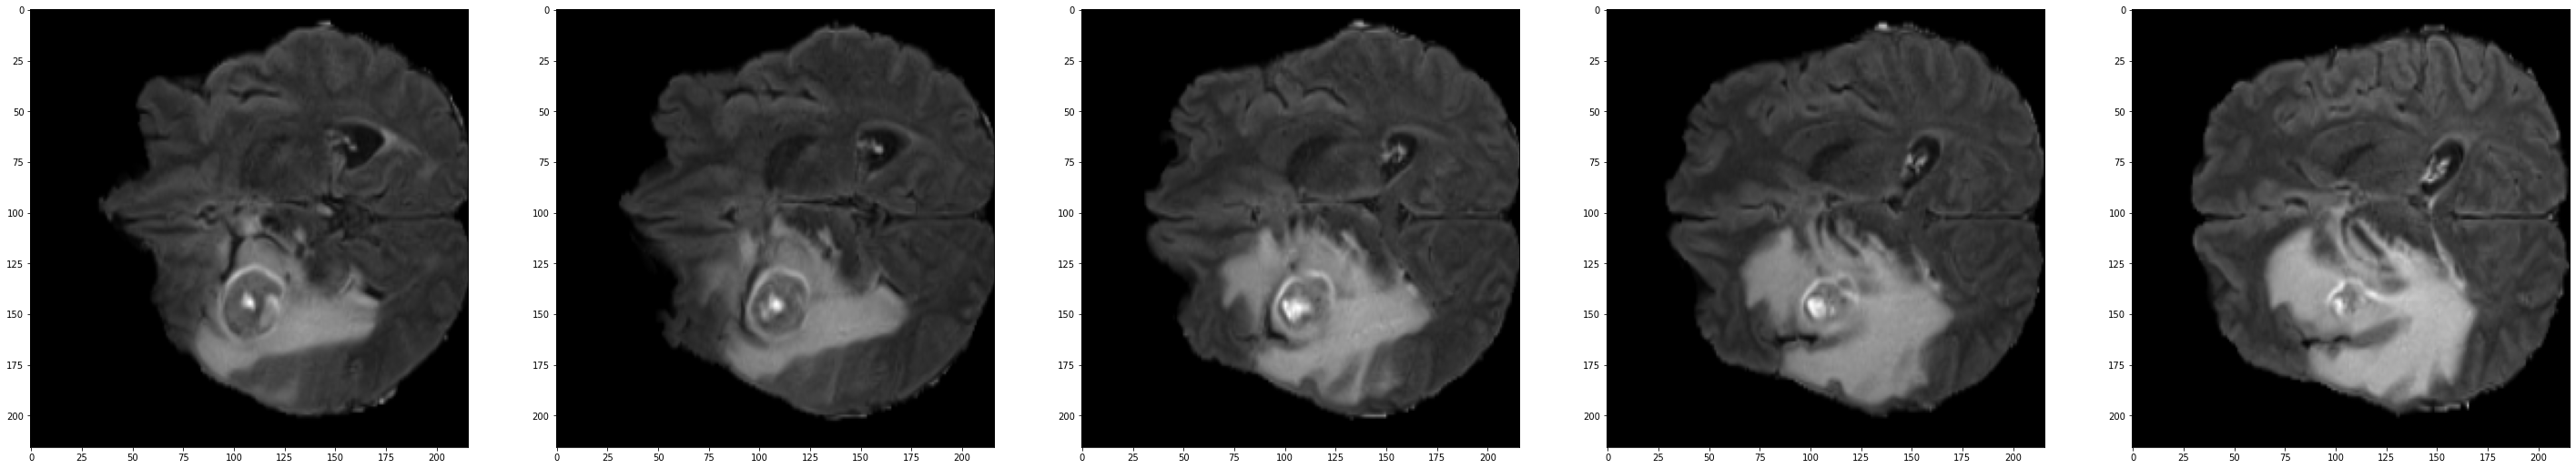

In [29]:
test_transforms()

<ipython-input-28-39614de3f7b3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["MRI_Type"] = 'FLAIR'


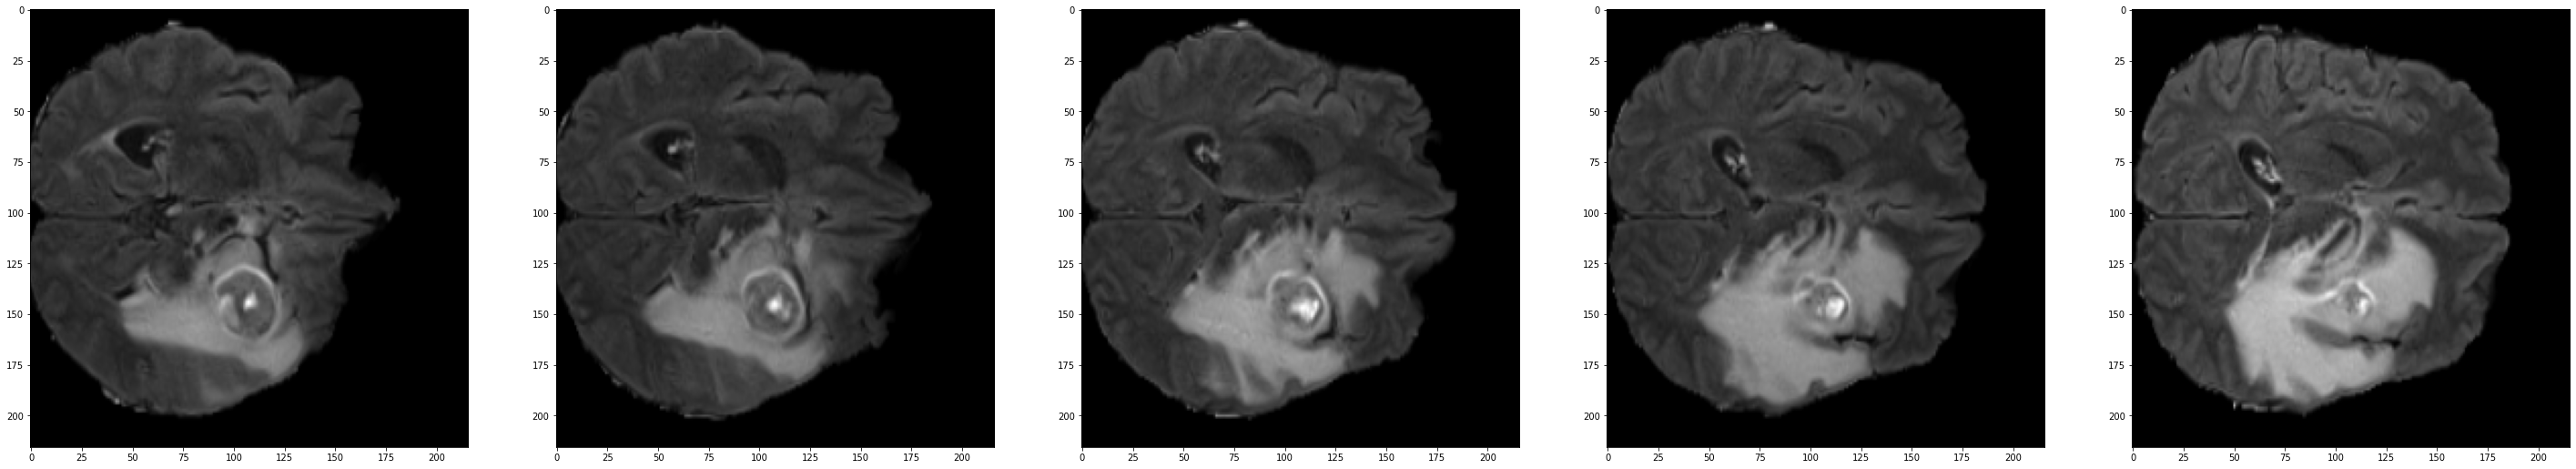

In [30]:
test_transforms()

<ipython-input-28-39614de3f7b3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["MRI_Type"] = 'FLAIR'


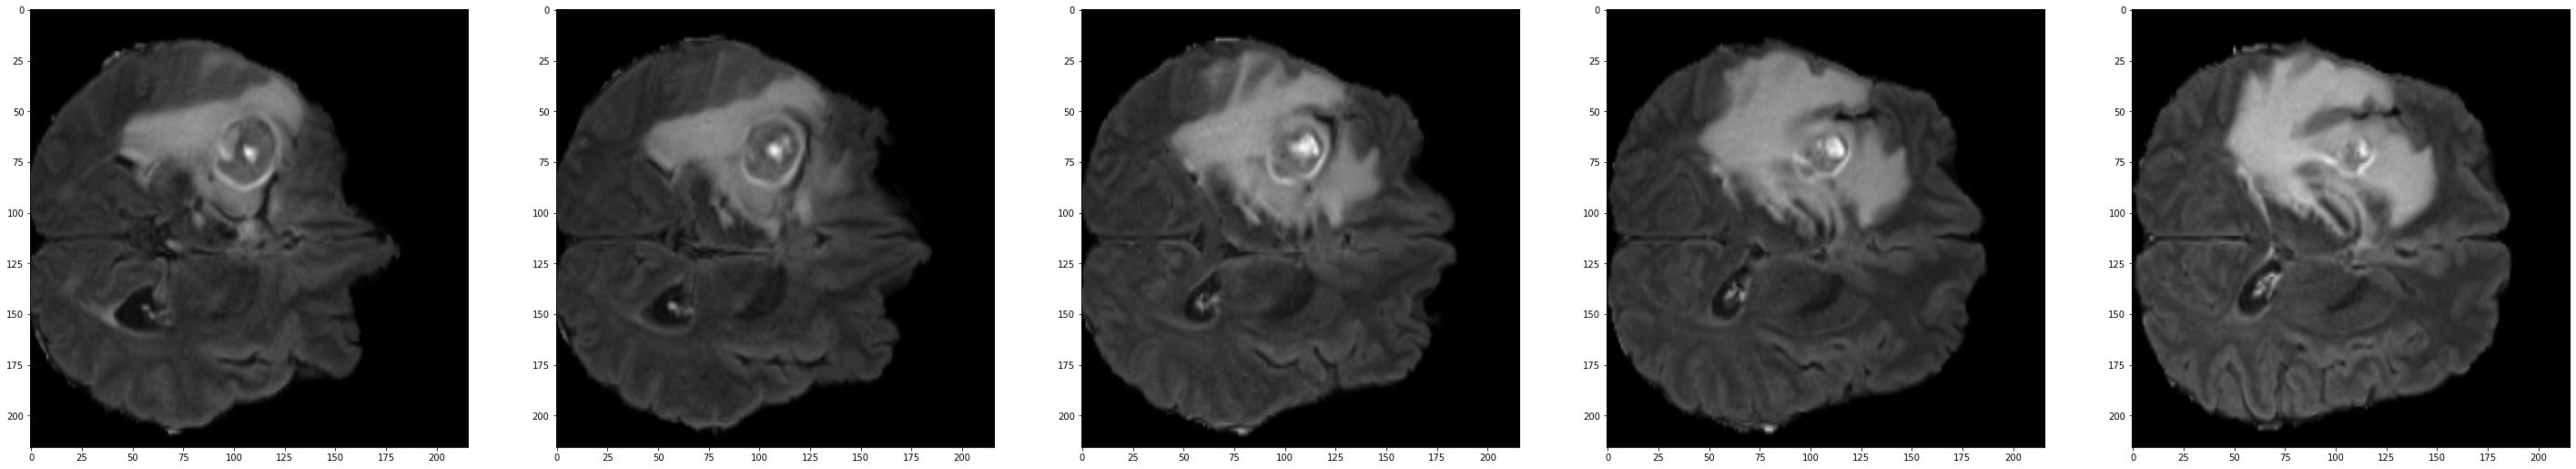

In [31]:
test_transforms()

In [32]:
# pooled_features = pretrained_model(sample_x['X'])
# pooled_features.view(pooled_features.size(0), -1).shape

In [33]:
# class Model(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.pretrained_model = models.alexnet(pretrained=True)
#         self.pooling_layer = nn.AdaptiveAvgPool2d(1)
#         self.classifer = nn.Linear(256, 1)

#     def forward(self, x):
#         x = torch.squeeze(x, dim=0) 
#         features = self.pretrained_model.features(x)
#         pooled_features = self.pooling_layer(features)
#         pooled_features = pooled_features.view(pooled_features.size(0), -1)
#         flattened_features = torch.max(pooled_features, 0, keepdim=True)[0]
#         output = self.classifer(flattened_features)
#         return output

In [34]:
dir(models)

['AlexNet',
 'DenseNet',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'Inception3',
 'InceptionOutputs',
 'MNASNet',
 'MobileNetV2',
 'ResNeXt',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 '_GoogLeNetOutputs',
 '_InceptionOutputs',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'mobilenetv2',
 'quantization',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext',
 'resnext101',
 'resnext101_32x8d',
 'resnext152',
 'resnext50',
 'resnext50_32x4d',
 'segmentation',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'shufflenet_v2_x1_5',
 'shufflenet_v2_x2_0',
 'shufflenetv2',
 'squeezenet',
 'squeezenet1_0',
 'squeezenet

In [35]:
# class Model(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.pretrained_model = models.resnext101()
#         modules=list(self.pretrained_model.children())[:-1]
#         self.pretrained_model=nn.Sequential(*modules)
#         self.pooling_layer = nn.AdaptiveAvgPool2d(1)
#         self.classifer = nn.Linear(2048, 1)

#     def forward(self, x):
#         x = torch.squeeze(x, dim=0) 
#         features = self.pretrained_model(x)
#         pooled_features = self.pooling_layer(features)
#         pooled_features = pooled_features.view(pooled_features.size(0), -1)
#         flattened_features = torch.max(pooled_features, 0, keepdim=True)[0]
#         output = self.classifer(flattened_features)
#         return output

In [39]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.pretrained_model = EfficientNet.from_name('efficientnet-b5')
        self.pooling_layer = nn.AdaptiveAvgPool2d(1)
        self.classifer = nn.Linear(2048, 1)

    def forward(self, x):
        x = torch.squeeze(x, dim=0) 
        features = self.pretrained_model.extract_features(x)
        pooled_features = self.pooling_layer(features)
        pooled_features = pooled_features.view(pooled_features.size(0), -1)
        flattened_features = torch.mean(pooled_features, 0, keepdim=True)[0]
        output = self.classifer(flattened_features)
        return output

In [40]:
df_train['MRI_Type'] = mri_types[0]

train_data_retriever = Dataset(
    df_train["BraTS21ID"].values, 
    df_train["MGMT_value"].values, 
    df_train["MRI_Type"].values
)
sample_record_0 = train_data_retriever[0]['X']
sample_model = Model()

<ipython-input-40-023744ee3b80>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['MRI_Type'] = mri_types[0]


In [41]:
sample_model(sample_record_0)

tensor([-0.1244], grad_fn=<AddBackward0>)

In [42]:
class Trainer:
    def __init__(
        self, 
        model, 
        device, 
        optimizer, 
        criterion
    ):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion

        self.best_valid_score = np.inf
        self.n_patience = 0
        self.lastmodel = None
        
    def fit(self, epochs, train_loader, valid_loader, save_path, patience):  
        tbar = tqdm(range(1, epochs + 1), total=epochs)
        self.lr_sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optimizer, T_0=int(len(train_loader)), T_mult=1, eta_min=0.0001, last_epoch=-1)
        self.lrs = []
        
        for n_epoch in tbar:
            
            self.info_message("EPOCH: {}", n_epoch)
            tbar.set_description(f'EPOCH: {n_epoch}')
            
            
            train_loss, train_time = self.train_epoch(train_loader)
            valid_loss, valid_auc, valid_time = self.valid_epoch(valid_loader)
            
            self.info_message(
                "[Epoch Train: {}] loss: {:.4f}, time: {:.2f} s            ",
                n_epoch, train_loss, train_time
            )
            
            self.info_message(
                "[Epoch Valid: {}] loss: {:.4f}, auc: {:.4f}, time: {:.2f} s",
                n_epoch, valid_loss, valid_auc, valid_time
            )

            # if True:
            # if self.best_valid_score < valid_auc: 
            if self.best_valid_score > valid_loss and n_epoch > 4 and valid_auc > 0.5: 
                self.save_model(n_epoch, save_path, valid_loss, valid_auc)
                self.info_message(
                     "auc improved from {:.4f} to {:.4f}. Saved model to '{}'", 
                    self.best_valid_score, valid_loss, self.lastmodel
                )
                self.best_valid_score = valid_loss
                self.n_patience = 0
            else:
                self.n_patience += 1
            
            if self.n_patience >= patience:
                self.info_message("\nValid auc didn't improve last {} epochs.", patience)
                break
        plt.plot(self.lrs)
            
    def train_epoch(self, train_loader):
        self.model.train()
        t = time.time()
        sum_loss = 0

        tbar = tqdm(enumerate(train_loader, 1), total=len(train_loader))
        
        for step, batch in tbar:
            X = batch["X"].squeeze().to(self.device)
            targets = batch["y"].to(self.device)
            
            self.optimizer.zero_grad()
            outputs = self.model(X)
            
            loss = self.criterion(outputs.view(-1), targets.view(-1))
            loss.backward()

            sum_loss += loss.detach().item()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            self.lr_sched.step()
            current_lr = self.optimizer.param_groups[0]["lr"]
            self.lrs.append(
                current_lr
            )
            
            message = 'Train Step {}/{}, train_loss: {:.4f}'
            self.info_message(message, step, len(train_loader), sum_loss/step, end="\r")
        
        return sum_loss/len(train_loader), int(time.time() - t)
    
    def valid_epoch(self, valid_loader):
        self.model.eval()
        t = time.time()
        sum_loss = 0
        y_all = []
        outputs_all = []

        tbar = tqdm(enumerate(valid_loader, 1), total=len(valid_loader))
        for step, batch in tbar:
            with torch.no_grad():
                X = batch["X"].squeeze().to(self.device)
                targets = batch["y"].to(self.device)

                
                outputs = self.model(X)
                outputs = torch.sigmoid(outputs)
                loss = self.criterion(outputs.view(-1), targets.view(-1))
                print('outputs', outputs[0].item(), 'targets', targets[0].item())
                
                sum_loss += loss.detach().item()
                y_all.extend(batch["y"].tolist())
                outputs_all.extend(outputs.tolist())

            message = 'Valid Step {}/{}, valid_loss: {:.4f}'
            self.info_message(message, step, len(valid_loader), sum_loss/step, end="\r")
            
        y_all = [1 if x > 0.5 else 0 for x in y_all]
        auc = roc_auc_score(y_all, outputs_all)
        
        return sum_loss/len(valid_loader), auc, int(time.time() - t)
    
    def save_model(self, n_epoch, save_path, loss, auc):
        self.lastmodel = str(cfg.models_path/f"{save_path}-e{n_epoch}-loss{loss:.3f}-auc{auc:.3f}.pth")
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
            },
            self.lastmodel,
        )
    
    @staticmethod
    def info_message(message, *args, end="\n"):
        print(message.format(*args), end=end)

In [43]:
def loss_func(input, target):
    return F.binary_cross_entropy_with_logits(input, target) * 0.5 + F.mse_loss(input, target) * 0.5

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_mri_type(df_train, df_valid, mri_type):
    if mri_type=="all":
        train_list = []
        valid_list = []
        for mri_type in mri_types:
            df_train.loc[:,"MRI_Type"] = mri_type
            train_list.append(df_train.copy())
            df_valid.loc[:,"MRI_Type"] = mri_type
            valid_list.append(df_valid.copy())

        df_train = pd.concat(train_list)
        df_valid = pd.concat(valid_list)
    else:
        df_train.loc[:,"MRI_Type"] = mri_type
        df_valid.loc[:,"MRI_Type"] = mri_type

    print(df_train.shape, df_valid.shape)
    display(df_train.head())
    
    train_data_retriever = Dataset(
        df_train["BraTS21ID"].values, 
        df_train["MGMT_value"].values, 
        df_train["MRI_Type"].values
    )

    valid_data_retriever = Dataset(
        df_valid["BraTS21ID"].values, 
        df_valid["MGMT_value"].values,
        df_valid["MRI_Type"].values
    )

    train_loader = torch_data.DataLoader(
        train_data_retriever,
        batch_size=cfg.batch_size,
        shuffle=True,
        num_workers=cfg.num_workers,
    )

    valid_loader = torch_data.DataLoader(
        valid_data_retriever, 
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=cfg.num_workers,
    )

    model = Model()
    model.to(device)

    #checkpoint = torch.load("best-model-all-auc0.555.pth")
    #model.load_state_dict(checkpoint["model_state_dict"])

    #print(model)

    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    criterion = loss_func

    trainer = Trainer(
        model, 
        device, 
        optimizer, 
        criterion
    )

    history = trainer.fit(
        cfg.epochs, 
        train_loader, 
        valid_loader, 
        f"{mri_type}", 
        cfg.epochs,
    )
    
    return trainer.lastmodel

In [45]:
!rm -rf {str(cfg.models_path)}/*.pth

In [46]:
torch.randn([1, 1]).view(-1).shape

torch.Size([1])

In [47]:
modelfiles = None

if not modelfiles:
    modelfiles = [train_mri_type(df_train, df_valid, m) for m in mri_types]
    print(modelfiles)

(552, 3) (30, 3)


/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


BraTS21ID  MGMT_value MRI_Type
514        751           0    FLAIR
144        217           0    FLAIR
61          97           0    FLAIR
464        676           1    FLAIR
46          71           1    FLAIR

EPOCH: 1


Train Step 552/552, train_loss: 0.5453


outputs 0.5173117518424988 targets 0.9900000095367432
outputs 0.5172625780105591 targets 0.009999999776482582
outputs 0.5172921419143677 targets 0.9900000095367432
outputs 0.5173514485359192 targets 0.009999999776482582
outputs 0.5172901153564453 targets 0.009999999776482582
outputs 0.5173014402389526 targets 0.9900000095367432
outputs 0.5172916054725647 targets 0.9900000095367432
outputs 0.5172929167747498 targets 0.009999999776482582
outputs 0.51729416847229 targets 0.009999999776482582
outputs 0.5172985792160034 targets 0.009999999776482582
outputs 0.5172879099845886 targets 0.009999999776482582
outputs 0.5172914266586304 targets 0.9900000095367432
outputs 0.5172863602638245 targets 0.9900000095367432
outputs 0.5172911286354065 targets 0.009999999776482582
outputs 0.517298698425293 targets 0.9900000095367432
outputs 0.5205815434455872 targets 0.9900000095367432
outputs 0.517293393611908 targets 0.9900000095367432
outputs 0.5176272392272949 targets 0.009999999776482582
outputs 0.5173

Train Step 552/552, train_loss: 0.5274


outputs 1.0 targets 0.9900000095367432
outputs 1.0 targets 0.009999999776482582
outputs 0.37326228618621826 targets 0.9900000095367432
outputs 1.0 targets 0.009999999776482582
outputs 0.9999998807907104 targets 0.009999999776482582
outputs 0.3732622563838959 targets 0.9900000095367432
outputs 0.3732672333717346 targets 0.9900000095367432
outputs 1.0 targets 0.009999999776482582
outputs 0.3734281659126282 targets 0.009999999776482582
outputs 0.9998891353607178 targets 0.009999999776482582
outputs 0.9745436906814575 targets 0.009999999776482582
outputs 1.0 targets 0.9900000095367432
outputs 0.9999990463256836 targets 0.9900000095367432
outputs 1.0 targets 0.009999999776482582
outputs 0.9995818734169006 targets 0.9900000095367432
outputs 0.37326332926750183 targets 0.9900000095367432
outputs 0.9055356383323669 targets 0.9900000095367432
outputs 0.9992275238037109 targets 0.009999999776482582
outputs 0.37325578927993774 targets 0.9900000095367432
outputs 0.9975716471672058 targets 0.990000

Train Step 552/552, train_loss: 0.5013


outputs 0.7022233009338379 targets 0.9900000095367432
outputs 0.7013042569160461 targets 0.009999999776482582
outputs 0.7012085318565369 targets 0.9900000095367432
outputs 0.7020566463470459 targets 0.009999999776482582
outputs 0.7033522129058838 targets 0.009999999776482582
outputs 0.7013350129127502 targets 0.9900000095367432
outputs 0.7012333869934082 targets 0.9900000095367432
outputs 0.7055267095565796 targets 0.009999999776482582
outputs 0.7011849880218506 targets 0.009999999776482582
outputs 0.6905409693717957 targets 0.009999999776482582
outputs 0.7012559175491333 targets 0.009999999776482582
outputs 0.7064321041107178 targets 0.9900000095367432
outputs 0.7022793292999268 targets 0.9900000095367432
outputs 0.689978837966919 targets 0.009999999776482582
outputs 0.701357901096344 targets 0.9900000095367432
outputs 0.70132976770401 targets 0.9900000095367432
outputs 0.6747300028800964 targets 0.9900000095367432
outputs 0.7011352181434631 targets 0.009999999776482582
outputs 0.7013

Train Step 552/552, train_loss: 0.4995


outputs 1.0 targets 0.9900000095367432
outputs 1.0 targets 0.009999999776482582
outputs 0.5756383538246155 targets 0.9900000095367432
outputs 1.0 targets 0.009999999776482582
outputs 1.0 targets 0.009999999776482582
outputs 0.5639479756355286 targets 0.9900000095367432
outputs 0.5690958499908447 targets 0.9900000095367432
outputs 0.5692814588546753 targets 0.009999999776482582
outputs 0.5639610886573792 targets 0.009999999776482582
outputs 0.5639493465423584 targets 0.009999999776482582
outputs 1.0 targets 0.009999999776482582
outputs 0.5638903975486755 targets 0.9900000095367432
outputs 0.9999942779541016 targets 0.9900000095367432
outputs 0.563920259475708 targets 0.009999999776482582
outputs 0.563934326171875 targets 0.9900000095367432
outputs 0.5639621615409851 targets 0.9900000095367432
outputs 0.5639331936836243 targets 0.9900000095367432
outputs 1.0 targets 0.009999999776482582
outputs 0.5639576315879822 targets 0.9900000095367432
outputs 1.0 targets 0.9900000095367432
outputs 1

Train Step 552/552, train_loss: 0.4871


outputs 1.0 targets 0.9900000095367432
outputs 0.9999356269836426 targets 0.009999999776482582
outputs 0.5098410844802856 targets 0.9900000095367432
outputs 0.9999324083328247 targets 0.009999999776482582
outputs 0.9822214245796204 targets 0.009999999776482582
outputs 0.5090497732162476 targets 0.9900000095367432
outputs 0.5086866021156311 targets 0.9900000095367432
outputs 0.5176666378974915 targets 0.009999999776482582
outputs 0.5099507570266724 targets 0.009999999776482582
outputs 0.5101463794708252 targets 0.009999999776482582
outputs 0.9999779462814331 targets 0.009999999776482582
outputs 0.5199348330497742 targets 0.9900000095367432
outputs 0.9998112320899963 targets 0.9900000095367432
outputs 0.5110141038894653 targets 0.009999999776482582
outputs 0.5110791921615601 targets 0.9900000095367432
outputs 0.508516788482666 targets 0.9900000095367432
outputs 0.5112990736961365 targets 0.9900000095367432
outputs 0.8255235552787781 targets 0.009999999776482582
outputs 0.509465217590332 

Train Step 552/552, train_loss: 0.4901


outputs 0.5118957161903381 targets 0.9900000095367432
outputs 0.51190185546875 targets 0.009999999776482582
outputs 0.5118915438652039 targets 0.9900000095367432
outputs 0.5119236707687378 targets 0.009999999776482582
outputs 0.5141690373420715 targets 0.009999999776482582
outputs 0.5117148756980896 targets 0.9900000095367432
outputs 0.5118843913078308 targets 0.9900000095367432
outputs 0.5570628046989441 targets 0.009999999776482582
outputs 0.5118158459663391 targets 0.009999999776482582
outputs 0.5116572380065918 targets 0.009999999776482582
outputs 0.5119099020957947 targets 0.009999999776482582
outputs 0.5105860233306885 targets 0.9900000095367432
outputs 0.5123822093009949 targets 0.9900000095367432
outputs 0.5116788148880005 targets 0.009999999776482582
outputs 0.5224882960319519 targets 0.9900000095367432
outputs 0.7402727007865906 targets 0.9900000095367432
outputs 0.5118150115013123 targets 0.9900000095367432
outputs 0.5118656754493713 targets 0.009999999776482582
outputs 0.51

Train Step 298/552, train_loss: 0.5213



KeyboardInterrupt: 

## Predict Function

In [ ]:
def predict(modelfile, df, mri_type, split):
    print("Predict:", modelfile, mri_type, df.shape)
    df.loc[:,"MRI_Type"] = mri_type
    data_retriever = Dataset(
        df.index.values, 
        mri_type=df["MRI_Type"].values,
        split=split
    )

    data_loader = torch_data.DataLoader(
        data_retriever,
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=8,
    )
   
    model = Model()
    model.to(device)
    
    checkpoint = torch.load(modelfile)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    
    y_pred = []
    ids = []

    for e, batch in enumerate(data_loader,1):
        print(f"{e}/{len(data_loader)}", end="\r")
        with torch.no_grad():
            tmp_pred = torch.sigmoid(model(batch["X"].to(device))).cpu().numpy().squeeze()
            print('tmp_pred', tmp_pred)
            if tmp_pred.size == 1:
                y_pred.append(tmp_pred)
            else:
                y_pred.extend(tmp_pred.tolist())
            ids.extend(batch["id"].numpy().tolist())
            
    preddf = pd.DataFrame({"BraTS21ID": ids, "MGMT_value": y_pred}) 
    preddf = preddf.set_index("BraTS21ID")
    return preddf

## Ensemble for validation

In [ ]:
df_valid = df_valid.set_index("BraTS21ID")

In [ ]:
df_valid["MGMT_pred"] = 0
for m, mtype in zip(modelfiles,  mri_types):
    pred = predict(m, df_valid, mtype, "train")
    df_valid["MGMT_pred"] += pred["MGMT_value"]
df_valid["MGMT_pred"] /= len(modelfiles)
auc = roc_auc_score(df_valid["MGMT_value"], df_valid["MGMT_pred"])
print(f"Validation ensemble AUC: {auc:.4f}")
sns.displot(df_valid["MGMT_pred"])

## Export to Kaggle

In [ ]:
!rm -rf {cfg.models_path/cfg.model_name}

In [ ]:
import shutil

if not Path(cfg.models_path/cfg.model_name).exists():
    os.mkdir(cfg.models_path/cfg.model_name)
for m in modelfiles:
    shutil.copy(m, cfg.models_path/cfg.model_name)
    
shutil.make_archive(cfg.models_path/cfg.model_name, 'zip', cfg.models_path/cfg.model_name)

In [ ]:
!du -h {cfg.models_path/cfg.model_name}

In [ ]:
!rm -rf {cfg.models_path}/*.pth
!rm -rf {cfg.models_path/cfg.model_name}/*.pth

In [ ]:
!mv {cfg.models_path/cfg.model_name}.zip {cfg.models_path/cfg.model_name}

In [ ]:
!kaggle datasets init -p {cfg.models_path/cfg.model_name}

In [ ]:
dataset_json_path = Path(cfg.models_path/cfg.model_name/'dataset-metadata.json')
assert dataset_json_path.exists()

In [ ]:
with open(dataset_json_path, 'r') as f:
    dataset_json = f.read()
    dataset_json = dataset_json.replace('INSERT_TITLE_HERE', f'rsna-{cfg.model_name}').replace('INSERT_SLUG_HERE', f'rsna-{cfg.model_name}')
    print(dataset_json)
with(open(dataset_json_path, 'w')) as f:
    f.write(dataset_json)

In [ ]:
# !kaggle datasets create -p {cfg.models_path/cfg.model_name}

In [ ]:
!kaggle datasets version -p {cfg.models_path/cfg.model_name} -m "Improved data set" -d